# Methodologies for image processing of radar remote sensing data #
## Lecture 5: Flood monitoring

In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np




### In this exercise, in order to be able to do change detection, two images are required, one with the flood (3 June 2011) and the other without it (1 October 2011). 

### Step 1: we will open data stored in GeoTIFF format. ###


In [3]:
# step 1: we will open data stored in GeoTIFF format.
#---3 June 2011 (with flood)-----
path = './'
file154B2 = 'LE70230362011154EDC00_B2.TIF'
file154B4 = 'LE70230362011154EDC00_B4.TIF'

with rasterio.open(path + file154B2) as src:
    img154B2 = src.read(1)  # Read band 1

with rasterio.open(path + file154B4) as src:
    img154B4 = src.read(1)  # Read band 1

#----1 October 2011 (without flood)---
file274B2 = 'LT50230362011274PAC01_B2.TIF'
file274B4 = 'LT50230362011274PAC01_B4.TIF'

with rasterio.open(path + file274B2) as src:
    img274B2 = src.read(1)  # Read band 1

with rasterio.open(path + file274B4) as src:
    img274B4 = src.read(1)  # Read band 1

## Step 2： Visualizing images & choice of Region of interest (ROI) ##

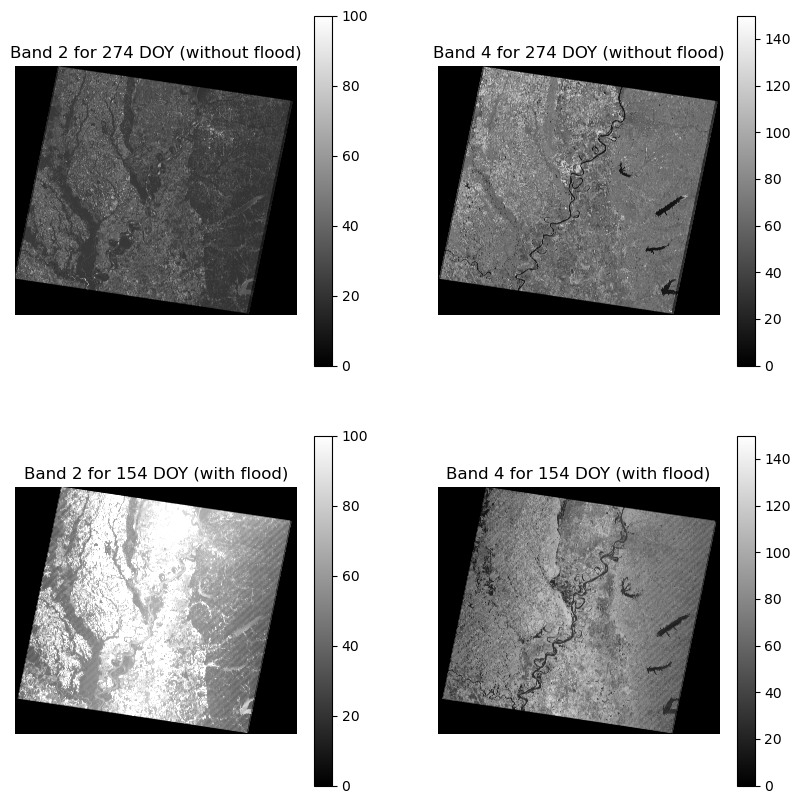

In [4]:
#--step 2： Visualizing images & choice of Region of interest (ROI)--------
# First you can visualise the images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot images in subfigures
im1 = axs[0, 0].imshow(img274B2, cmap='gray', vmin=0, vmax=100)
axs[0, 0].set_title('Band 2 for 274 DOY (without flood)')
axs[0, 0].axis('off')
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(img274B4, cmap='gray', vmin=0, vmax=150)
axs[0, 1].set_title('Band 4 for 274 DOY (without flood)')
axs[0, 1].axis('off')
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(img154B2, cmap='gray', vmin=0, vmax=100)
axs[1, 0].set_title('Band 2 for 154 DOY (with flood)')
axs[1, 0].axis('off')
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(img154B4, cmap='gray', vmin=0, vmax=150)
axs[1, 1].set_title('Band 4 for 154 DOY (with flood)')
axs[1, 1].axis('off')
fig.colorbar(im4, ax=axs[1, 1])

# Save the figure
#plt.savefig('visualize_images.png', bbox_inches='tight') # save the figure to file
plt.show()


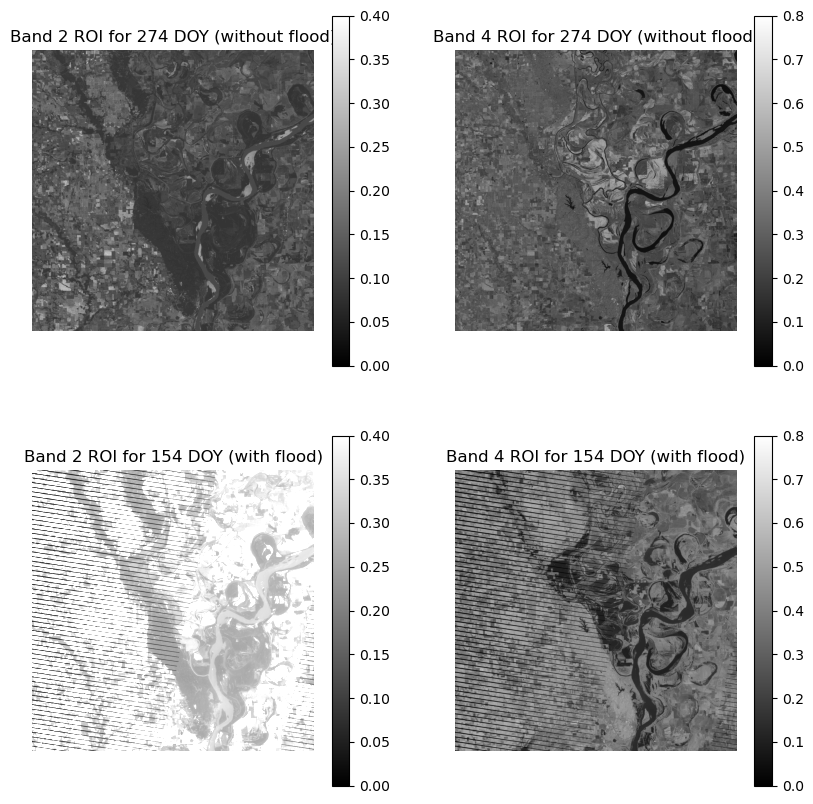

In [5]:
# then you can choose the area of interest and plot it
# Here there is a suggestion regarding an area, please feel free to spot other interesting regions in the image
B2_274 = img274B2[1999:3999, 2499:4499]
B4_274 = img274B4[1999:3999, 2499:4499]
B2_154 = img154B2[1999:3999, 2499:4499]
B4_154 = img154B4[1999:3999, 2499:4499]

# Convert images to double precision and normalize
B2_274 = B2_274.astype(float) / 255.0
B4_274 = B4_274.astype(float) / 255.0
B2_154 = B2_154.astype(float) / 255.0
B4_154 = B4_154.astype(float) / 255.0

# Display ROI
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display ROI in subfigures
im1 = axs[0, 0].imshow(B2_274, cmap='gray',vmin=0,vmax=0.4)
axs[0, 0].set_title('Band 2 ROI for 274 DOY (without flood)')
axs[0, 0].axis('off')
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(B4_274, cmap='gray',vmin=0,vmax=0.8)
axs[0, 1].set_title('Band 4 ROI for 274 DOY (without flood)')
axs[0, 1].axis('off')
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(B2_154, cmap='gray',vmin=0,vmax=0.4)
axs[1, 0].set_title('Band 2 ROI for 154 DOY (with flood)')
axs[1, 0].axis('off')
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(B4_154, cmap='gray',vmin=0,vmax=0.8)
axs[1, 1].set_title('Band 4 ROI for 154 DOY (with flood)')
axs[1, 1].axis('off')
fig.colorbar(im4, ax=axs[1, 1])

# Save the figure
#plt.savefig('visualize_roi.png', bbox_inches='tight')
plt.show()

## Step 3: image coregistration

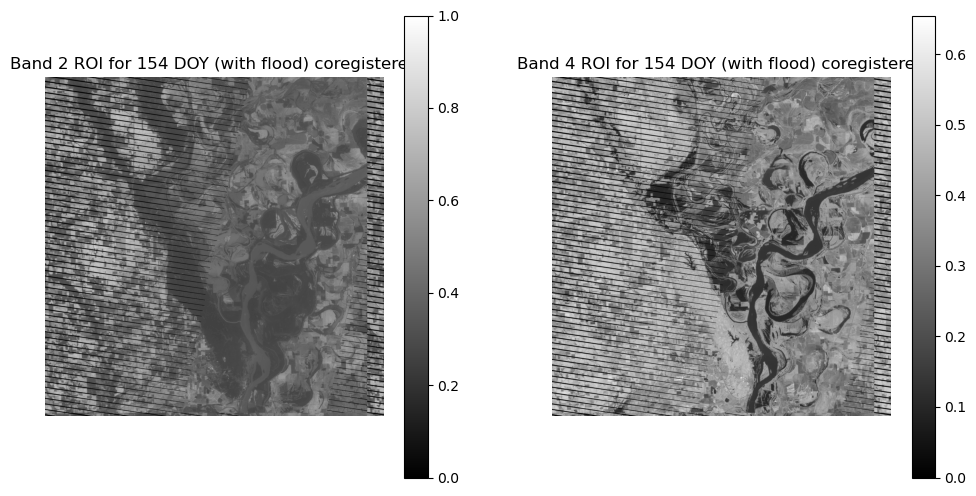

In [6]:
#--step 3: image coregistration----------------------
from scipy.fft import fft2, ifft2

# Perform FFT on the images
I1 = fft2(B2_274)
I2 = fft2(B2_154)

# Calculate the energy of the image patches
E1 = np.sum(B2_274 ** 2)
E2 = np.sum(B2_154 ** 2)

# Calculate the product in the frequency domain
Prodn = I1 * np.conj(I2) / np.sqrt(E1 * E2)

# Calculate the correlation using inverse FFT
Corr = ifft2(Prodn)

# Find the maximum correlation value and its position
maxValue = np.max(np.abs(Corr))
xMax, yMax = np.where(np.abs(Corr) == maxValue)

# Apply the shift to one acquisition
B2_154_shift = np.roll(B2_154, (xMax[0]+1, yMax[0]+1), axis=(0, 1)) # xMax[0] is the index number from 0, moving step should +1
B4_154_shift = np.roll(B4_154, (xMax[0]+1, yMax[0]+1), axis=(0, 1))

# Display the registered images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

im1 = axs[0].imshow(B2_154_shift, cmap='gray')
axs[0].set_title('Band 2 ROI for 154 DOY (with flood) coregistered')
axs[0].axis('off')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(B4_154_shift, cmap='gray')
axs[1].set_title('Band 4 ROI for 154 DOY (with flood) coregistered')
axs[1].axis('off')
fig.colorbar(im2, ax=axs[1])

# Save the figure
#plt.savefig('ROI_coregistered.png', bbox_inches='tight')
plt.show()

## Step 4: Estimation of the Normalised Difference Water Index for the two dates

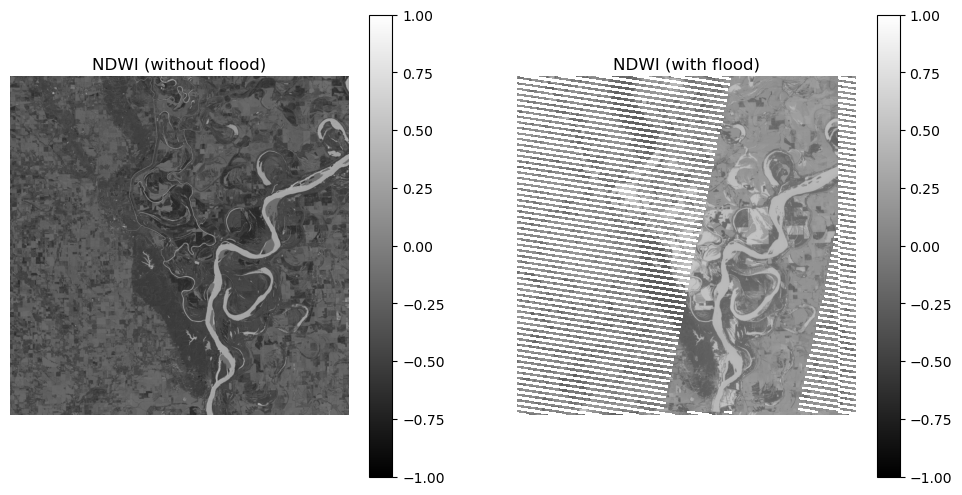

In [7]:
#---step 4: Estimation of the Normalised Difference Water Index for the two dates----
B2_274[B2_274 == 0] = np.nan
B4_274[B4_274 == 0] = np.nan
B2_154_shift[B2_154_shift == 0] = np.nan
B4_154_shift[B4_154_shift == 0] = np.nan

# Calculate NDWI for the two dates
NDWI_274 = (B2_274 - B4_274) / (B2_274 + B4_274)
NDWI_154 = (B2_154_shift - B4_154_shift) / (B2_154_shift + B4_154_shift)

# Display NDWI images in subfigures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(NDWI_274, vmin=-1, vmax=1, cmap='gray')
axs[0].set_title('NDWI (without flood)')
axs[0].axis('off')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(NDWI_154, vmin=-1, vmax=1, cmap='gray')
axs[1].set_title('NDWI (with flood)')
axs[1].axis('off')
fig.colorbar(im2, ax=axs[1])

# Save the figure
#plt.savefig('NDWI.png', bbox_inches='tight')
plt.show()

## Step 5: Detecting flood

We will introduce two methods:
1. Using NIR channel
2. Using NDWI

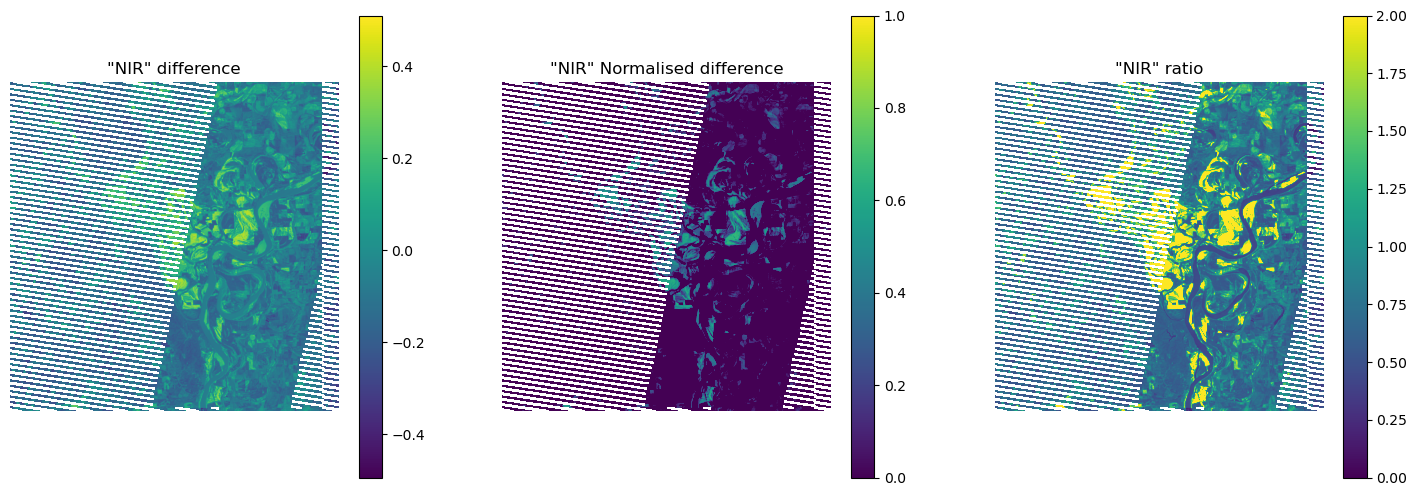

In [8]:
#---step 5: Detecting flood--------------

# First method: Detector with single channel: NIR (band-4) is a good candidate to use
# NIR Difference
Diff_B4 = B4_274 - B4_154_shift

# Normalised Difference
DiffN_B4 = (B4_274 - B4_154_shift) / (B4_274 + B4_154_shift)

# Ratio
Ratio_B4 = B4_274 / B4_154_shift

# Display NIR channel results in subfigures
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
im1 = axs[0].imshow(Diff_B4)
axs[0].set_title('"NIR" difference')
axs[0].axis('off')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(DiffN_B4, vmin=0, vmax=1)
axs[1].set_title('"NIR" Normalised difference')
axs[1].axis('off')
fig.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(Ratio_B4, vmin=0, vmax=2)
axs[2].set_title('"NIR" ratio')
axs[2].axis('off')
fig.colorbar(im3, ax=axs[2])

# Save the figure
#plt.savefig('subfigures_nir_channel_results.png', bbox_inches='tight')
plt.show()

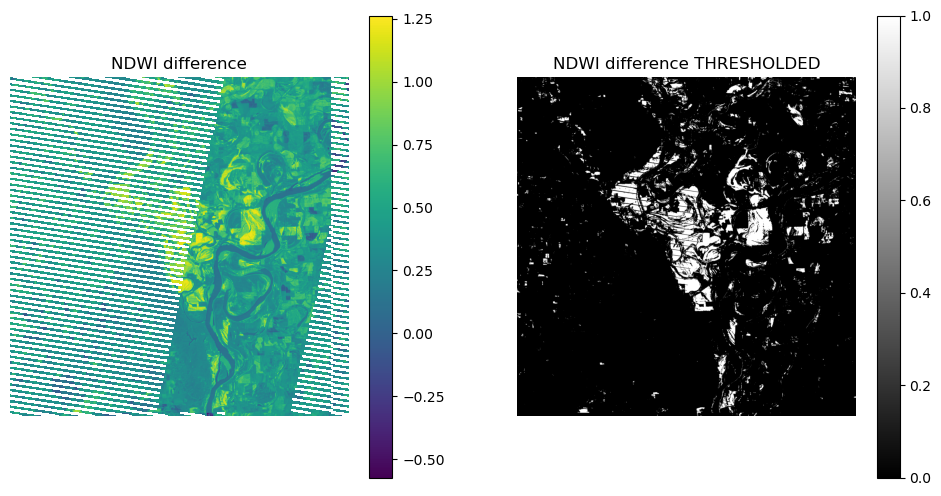

In [9]:
# Second method: Detector with two channels: differences in the NDWI can be estimated
# NDWI Difference
Diff_NDWI = NDWI_154 - NDWI_274

# plot the detection results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display NDWI difference in subfigures
im1 = axs[0].imshow(Diff_NDWI, cmap='viridis')
axs[0].set_title('NDWI difference')
axs[0].axis('off')
fig.colorbar(im1, ax=axs[0])

# Thresholding NDWI difference
im2 = axs[1].imshow(Diff_NDWI > 0.75, cmap='gray') # 0.75 is the threshold, try to change it to see the difference and choose #the best one
axs[1].set_title('NDWI difference THRESHOLDED')
axs[1].axis('off')
fig.colorbar(im2, ax=axs[1])

# Save the figure
#plt.savefig('subfigures_ndwi_thresholding.png', bbox_inches='tight')

plt.show()